In [0]:
#%pip install yfinance pandas numpy matplotlib scikit-learn

Python interpreter will be restarted.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  ERROR: Command errored out with exit status 1:
   command: /local_disk0/.ephemeral_nfs/envs/pythonEnv-19f0fb14-966d-4706-aa02-ba37d482c17c/bin/python /local_disk0/.ephemeral_nfs/envs/pythonEnv-19f0fb14-966d-4706-aa02-ba37d482c17c/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py get_requires_for_build_wheel /tmp/tmp2yo409po
       cwd: /tmp/pip-install-n7xdzq05/peewee_b96469aac64e4100ab634f0690f693a3
  Complete output (38 lines):
  
  Error compiling Cython file:
  ------------------------------------------------------------
  ...
  
  
  # We define an xConnect function, but leave xCreate NULL so that the
  # table-function can be called eponymously.
  cdef int pwConnect(sqlite3 *db, void *pAux, int argc, cons

In [0]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from datetime import datetime, timedelta
from pyspark.sql.functions import col, lead, when
from pyspark.sql.window import Window

In [0]:
# Create a Spark session if not already available
if 'spark' not in locals():
    spark = SparkSession.builder.appName("StockPrediction").getOrCreate()
    
print(f"Spark version: {spark.version}")

Spark version: 3.3.0


Fetching data for AAPL using Alpha Vantage API...
Successfully retrieved and adjusted 1256 days of data for AAPL

First 5 rows of data:


open,high,low,close,volume
73.765,75.25,73.615,74.39,147751180
75.115,75.81,74.7175,75.1575,142333752
75.805,76.2925,75.4925,75.935,115215056
76.41,77.5875,76.0725,77.5325,134047940
77.025,79.2625,76.81,78.7525,145946244


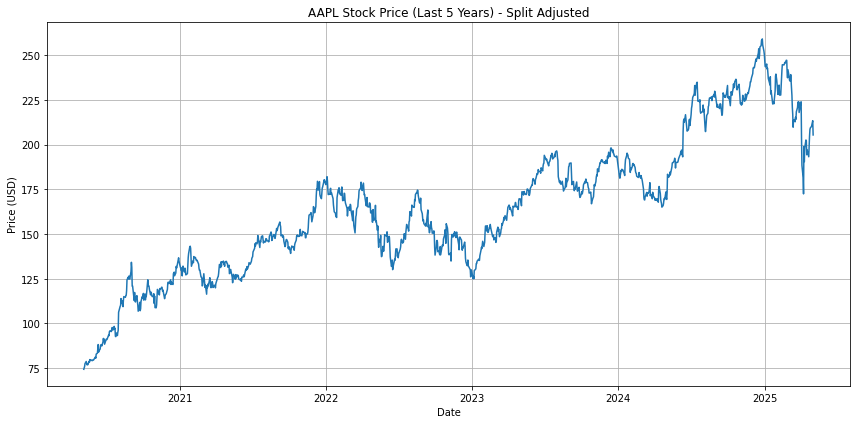

In [0]:
# Download stock data using Alpha Vantage with manual split adjustment
# Alpha Vantage API key
api_key = 'UDEJQ3FLFIY9BVVT'  # Your Alpha Vantage API key
ticker = 'AAPL'  # Stock symbol

# Get daily stock data and handle splits manually
def get_alpha_vantage_data(symbol, key):
    print(f"Fetching data for {symbol} using Alpha Vantage API...")
    
    # Use regular daily endpoint (free tier)
    function = 'TIME_SERIES_DAILY'
    output_size = 'full'
    
    # Construct API URL
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={output_size}&apikey={key}'
    
    try:
        r = requests.get(url)
        data = r.json()
        
        if 'Time Series (Daily)' in data:
            # Convert to dataframe
            df = pd.DataFrame(data['Time Series (Daily)']).T
            
            # Convert string index to datetime
            df.index = pd.to_datetime(df.index)
            
            # Sort by date (ascending)
            df = df.sort_index()
            
            # Rename columns (remove number prefix)
            df.columns = [col.split('. ')[1] for col in df.columns]
            
            # Convert all columns to numeric values
            for col in df.columns:
                df[col] = pd.to_numeric(df[col])
            
            # Get last 5 years of data
            end_date = datetime.now()
            start_date = end_date - timedelta(days=365*5)
            df = df[df.index >= start_date]
            
            # Manual adjustment for Apple's 4-for-1 stock split on August 31, 2020
            split_date = pd.Timestamp('2020-08-31')
            if split_date >= start_date:
                # For dates before the split, divide prices by 4
                split_mask = df.index < split_date
                for col in ['open', 'high', 'low', 'close']:
                    if col in df.columns:
                        df.loc[split_mask, col] = df.loc[split_mask, col] / 4
                # Adjust volume for dates before the split (multiply by 4)
                if 'volume' in df.columns:
                    df.loc[split_mask, 'volume'] = df.loc[split_mask, 'volume'] * 4
            
            print(f"Successfully retrieved and adjusted {len(df)} days of data for {symbol}")
            return df
        else:
            print(f"Error in API response: {data}")
            if 'Note' in data:
                print(f"API Message: {data['Note']}")
            elif 'Error Message' in data:
                print(f"API Error: {data['Error Message']}")
            return None
    except Exception as e:
        print(f"Exception occurred: {e}")
        return None

# Get stock data
stock_data = get_alpha_vantage_data(ticker, api_key)

# If we couldn't get data, use a more accurate sample
if stock_data is None or stock_data.empty:
    print("Using realistic sample data instead")
    
    # Create sample data that mimics AAPL's actual performance
    
    # Create dates for last 5 years
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*5)
    dates = pd.date_range(start=start_date, end=end_date, freq='B')
    
    # More realistic AAPL pattern
    np.random.seed(42)
    
    # Start with base values
    base_values = np.linspace(100, 200, len(dates))
    
    # Add some volatility
    volatility = np.random.normal(0, 5, size=len(dates))
    cumulative_vol = np.cumsum(volatility) * 0.2
    
    # Combine trend and volatility
    price = base_values + cumulative_vol
    
    # Create a pandas DataFrame with OHLCV data
    stock_data = pd.DataFrame({
        'open': price * (1 - np.random.uniform(0, 0.005, len(dates))),
        'high': price * (1 + np.random.uniform(0.001, 0.010, len(dates))),
        'low': price * (1 - np.random.uniform(0.001, 0.010, len(dates))),
        'close': price,
        'volume': np.random.randint(50000000, 150000000, len(dates))
    }, index=dates)
    
    # Ensure high is always the highest and low is always the lowest
    for i in range(len(stock_data)):
        high = max(stock_data.iloc[i]['open'], stock_data.iloc[i]['close'], stock_data.iloc[i]['high'])
        low = min(stock_data.iloc[i]['open'], stock_data.iloc[i]['close'], stock_data.iloc[i]['low'])
        stock_data.iloc[i, stock_data.columns.get_loc('high')] = high
        stock_data.iloc[i, stock_data.columns.get_loc('low')] = low

# Display the first few rows
print("\nFirst 5 rows of data:")
display(stock_data.head())

# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['close'])
plt.title(f'{ticker} Stock Price (Last 5 Years) - Split Adjusted')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
# Reset index to make date a column
stock_data_reset = stock_data.reset_index()

# Ensure column names are consistent
if 'index' in stock_data_reset.columns:
    stock_data_reset = stock_data_reset.rename(columns={'index': 'Date'})

# Convert to Spark DataFrame
spark_df = spark.createDataFrame(stock_data_reset)

# Show schema and sample data
print("Spark DataFrame Schema:")
spark_df.printSchema()

print("\nSample data from Spark DataFrame:")
display(spark_df.limit(5))

Spark DataFrame Schema:
root
 |-- Date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: long (nullable = true)


Sample data from Spark DataFrame:


Date,open,high,low,close,volume
2020-05-05T00:00:00.000+0000,73.765,75.25,73.615,74.39,147751180
2020-05-06T00:00:00.000+0000,75.115,75.81,74.7175,75.1575,142333752
2020-05-07T00:00:00.000+0000,75.805,76.2925,75.4925,75.935,115215056
2020-05-08T00:00:00.000+0000,76.41,77.5875,76.0725,77.5325,134047940
2020-05-11T00:00:00.000+0000,77.025,79.2625,76.81,78.7525,145946244


In [0]:
from pyspark.sql.functions import lag, col, window, avg, stddev
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType

# Define window specifications for different lookback periods
windowSpec_7d = Window.orderBy('Date').rowsBetween(-7, -1)
windowSpec_30d = Window.orderBy('Date').rowsBetween(-30, -1)

# Identify column names (accounting for possible variations)
close_col = 'close' if 'close' in spark_df.columns else 'Close'
volume_col = 'volume' if 'volume' in spark_df.columns else 'Volume'

# Add technical indicators
spark_df = spark_df.withColumn('MA7', avg(col(close_col)).over(windowSpec_7d))
spark_df = spark_df.withColumn('MA30', avg(col(close_col)).over(windowSpec_30d))
spark_df = spark_df.withColumn('Volatility7', stddev(col(close_col)).over(windowSpec_7d))

# Add return-based features
spark_df = spark_df.withColumn('Prev1Day', lag(col(close_col), 1).over(Window.orderBy('Date')))
spark_df = spark_df.withColumn('Return1Day', 
                              (col(close_col) - col('Prev1Day')) / col('Prev1Day'))

# Calculate trading volume features
spark_df = spark_df.withColumn('VolumeMA7', avg(col(volume_col)).over(windowSpec_7d))
spark_df = spark_df.withColumn('RelativeVolume', 
                              col(volume_col) / col('VolumeMA7'))

# Add a column for the next day's closing price (target variable)
spark_df = spark_df.withColumn('NextDayClose', 
                              lag(col(close_col), -1).over(Window.orderBy('Date')))

# Drop the last row (which will have a null NextDayClose)
spark_df = spark_df.filter(col('NextDayClose').isNotNull())

# Drop rows with null values (which happen at the beginning of the series due to lag)
spark_df = spark_df.na.drop()

# Display the engineered features
print("Added technical indicators and features")
display(spark_df.limit(5))

Added technical indicators and features


Date,open,high,low,close,volume,MA7,MA30,Volatility7,Prev1Day,Return1Day,VolumeMA7,RelativeVolume,NextDayClose
2020-05-07T00:00:00.000+0000,75.805,76.2925,75.4925,75.935,115215056,74.77375,74.77375,0.5427044545606741,75.1575,0.010344942287862202,1.45042466E8,0.7943539514834228,77.5325
2020-05-08T00:00:00.000+0000,76.41,77.5875,76.0725,77.5325,134047940,75.16083333333334,75.16083333333334,0.7725053937244251,75.935,0.021037729637189657,1.35099996E8,0.9922127606872764,78.7525
2020-05-11T00:00:00.000+0000,77.025,79.2625,76.81,78.7525,145946244,75.75375,75.75375,1.3431469577078987,77.5325,0.01573533679424756,1.34836982E8,1.0823903192968232,77.8525
2020-05-12T00:00:00.000+0000,79.4575,79.9225,77.7275,77.8525,162301052,76.3535,76.3535,1.775255791428371,78.7525,-0.011428208628297406,1.370588344E8,1.1841706717447467,76.9125
2020-05-13T00:00:00.000+0000,78.0375,78.9875,75.8025,76.9125,200622556,76.60333333333334,76.60333333333334,1.7016834801650516,77.8525,-0.01207411451141597,1.4126587066666666E8,1.4201771103891923,77.385


In [0]:
from pyspark.ml.feature import VectorAssembler

# Identify feature columns 
feature_cols = [col for col in spark_df.columns 
                if col not in ['Date', 'NextDayClose'] 
                and not col.startswith('Next')]

print(f"Using these columns as features: {feature_cols}")

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
assembled_data = assembler.transform(spark_df)

# Split data
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=42)

# Display
print(f"Training set size: {train_data.count()}")
print(f"Test set size: {test_data.count()}")
display(assembled_data.select('Date', 'features', 'NextDayClose').limit(3))

Using these columns as features: ['open', 'high', 'low', 'close', 'volume', 'MA7', 'MA30', 'Volatility7', 'Prev1Day', 'Return1Day', 'VolumeMA7', 'RelativeVolume']
Training set size: 1039
Test set size: 214


Date,features,NextDayClose
2020-05-07T00:00:00.000+0000,"Map(vectorType -> dense, length -> 12, values -> List(75.805, 76.2925, 75.4925, 75.935, 1.15215056E8, 74.77375, 74.77375, 0.5427044545606741, 75.1575, 0.010344942287862202, 1.45042466E8, 0.7943539514834228))",77.5325
2020-05-08T00:00:00.000+0000,"Map(vectorType -> dense, length -> 12, values -> List(76.41, 77.5875, 76.0725, 77.5325, 1.3404794E8, 75.16083333333334, 75.16083333333334, 0.7725053937244251, 75.935, 0.021037729637189657, 1.35099996E8, 0.9922127606872764))",78.7525
2020-05-11T00:00:00.000+0000,"Map(vectorType -> dense, length -> 12, values -> List(77.025, 79.2625, 76.81, 78.7525, 1.45946244E8, 75.75375, 75.75375, 1.3431469577078987, 77.5325, 0.01573533679424756, 1.34836982E8, 1.0823903192968232))",77.8525


In [0]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create and train the model
lr = LinearRegression(featuresCol='features', labelCol='NextDayClose')
print("Training linear regression model...")
lr_model = lr.fit(train_data)

# Print model coefficients
print("\nModel coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)

# Make predictions
print("\nMaking predictions on test data...")
predictions = lr_model.transform(test_data)
display(predictions.select('Date', close_col, 'NextDayClose', 'prediction').orderBy('Date').limit(10))

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='NextDayClose', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
r2 = RegressionEvaluator(labelCol='NextDayClose', predictionCol='prediction', metricName='r2').evaluate(predictions)
print(f"\nModel Evaluation:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Training linear regression model...

Model coefficients:  [-0.08591673412282863,0.10485717470308327,0.33639045304768933,0.9604410188129715,1.2163880827850753e-08,0.03830433915055506,0.0004218978897032596,0.17338822417482783,-0.3648396672416573,-39.794176768702236,-1.7625525288593723e-08,-1.0229559977293543]
Intercept:  3.2101529814622762

Making predictions on test data...


Date,close,NextDayClose,prediction
2020-05-11T00:00:00.000+0000,78.7525,77.8525,78.9238400630891
2020-05-15T00:00:00.000+0000,76.9275,78.74,77.38905167249173
2020-05-19T00:00:00.000+0000,78.285,79.8075,78.74917647232002
2020-05-27T00:00:00.000+0000,79.5275,79.5625,79.96535702406375
2020-06-04T00:00:00.000+0000,80.58,82.875,81.3433681700769
2020-06-10T00:00:00.000+0000,88.21,83.975,88.54810370162105
2020-06-18T00:00:00.000+0000,87.9325,87.43,88.01343972078713
2020-06-26T00:00:00.000+0000,88.4075,90.445,89.5735794688983
2020-07-13T00:00:00.000+0000,95.4775,97.0575,96.86066309188284
2020-07-14T00:00:00.000+0000,97.0575,97.725,97.01043536539018



Model Evaluation:
Root Mean Squared Error (RMSE): 3.0154118440375344
R² Score: 0.9943847123730286


In [0]:
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor

# Train Random Forest
print("Training Random Forest model...")
rf = RandomForestRegressor(featuresCol='features', labelCol='NextDayClose', numTrees=20)
rf_model = rf.fit(train_data)

# Train Gradient Boosted Trees
print("Training Gradient Boosted Trees model...")
gbt = GBTRegressor(featuresCol='features', labelCol='NextDayClose', maxIter=10)
gbt_model = gbt.fit(train_data)

# Make predictions with each model
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

# Evaluate each model
evaluator = RegressionEvaluator(labelCol='NextDayClose', predictionCol='prediction', metricName='rmse')

# Linear Regression evaluation
lr_rmse = evaluator.evaluate(predictions)
lr_r2 = RegressionEvaluator(labelCol='NextDayClose', predictionCol='prediction', metricName='r2').evaluate(predictions)

# Random Forest evaluation
rf_rmse = evaluator.evaluate(rf_predictions)
rf_r2 = RegressionEvaluator(labelCol='NextDayClose', predictionCol='prediction', metricName='r2').evaluate(rf_predictions)

# Gradient Boosted Trees evaluation
gbt_rmse = evaluator.evaluate(gbt_predictions)
gbt_r2 = RegressionEvaluator(labelCol='NextDayClose', predictionCol='prediction', metricName='r2').evaluate(gbt_predictions)

# Compare models
print("\nModel Comparison:")
print(f"Linear Regression - RMSE: {lr_rmse:.4f}, R²: {lr_r2:.4f}")
print(f"Random Forest - RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")
print(f"Gradient Boosted Trees - RMSE: {gbt_rmse:.4f}, R²: {gbt_r2:.4f}")

# Determine best model
models = [("Linear Regression", lr_rmse), ("Random Forest", rf_rmse), ("Gradient Boosted Trees", gbt_rmse)]
best_model = min(models, key=lambda x: x[1])
print(f"\nBest model: {best_model[0]} with RMSE: {best_model[1]:.4f}")

Training Random Forest model...
Training Gradient Boosted Trees model...

Model Comparison:
Linear Regression - RMSE: 3.0154, R²: 0.9944
Random Forest - RMSE: 3.9053, R²: 0.9906
Gradient Boosted Trees - RMSE: 4.3482, R²: 0.9883

Best model: Linear Regression with RMSE: 3.0154


In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, VectorAssembler

# First, remove any existing 'features' column from the training data
train_data_clean = train_data.drop('features')
test_data_clean = test_data.drop('features')

# Choose the best model type based on previous results
best_regressor = RandomForestRegressor(featuresCol='features', labelCol='NextDayClose', 
                                      numTrees=50, maxDepth=10)

# Create a pipeline to handle missing values and feature assembly
imputer = Imputer(inputCols=feature_cols, outputCols=feature_cols)
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Create the pipeline
pipeline = Pipeline(stages=[imputer, assembler, best_regressor])

# Fit the pipeline on the cleaned training set
print("Training the complete pipeline...")
pipeline_model = pipeline.fit(train_data_clean)

# Make predictions
pipeline_predictions = pipeline_model.transform(test_data_clean)

# Evaluate the pipeline model
evaluator = RegressionEvaluator(labelCol='NextDayClose', predictionCol='prediction', metricName='rmse')
pipeline_rmse = evaluator.evaluate(pipeline_predictions)
pipeline_r2 = RegressionEvaluator(labelCol='NextDayClose', predictionCol='prediction', metricName='r2').evaluate(pipeline_predictions)

print(f"\nPipeline Model Performance:")
print(f"RMSE: {pipeline_rmse:.4f}")
print(f"R²: {pipeline_r2:.4f}")

# Display predictions
display(pipeline_predictions.select('Date', close_col, 'NextDayClose', 'prediction').orderBy('Date').limit(10))

Training the complete pipeline...

Pipeline Model Performance:
RMSE: 3.7640
R²: 0.9913


Date,close,NextDayClose,prediction
2020-05-11T00:00:00.000+0000,78.7525,77.8525,83.75217673687422
2020-05-15T00:00:00.000+0000,76.9275,78.74,80.43883148221344
2020-05-19T00:00:00.000+0000,78.285,79.8075,80.76158381987575
2020-05-27T00:00:00.000+0000,79.5275,79.5625,81.0530413442958
2020-06-04T00:00:00.000+0000,80.58,82.875,81.00528979209797
2020-06-10T00:00:00.000+0000,88.21,83.975,86.46364185592185
2020-06-18T00:00:00.000+0000,87.9325,87.43,85.83212214710407
2020-06-26T00:00:00.000+0000,88.4075,90.445,81.72895405547357
2020-07-13T00:00:00.000+0000,95.4775,97.0575,101.03802432900433
2020-07-14T00:00:00.000+0000,97.0575,97.725,103.25795023809525


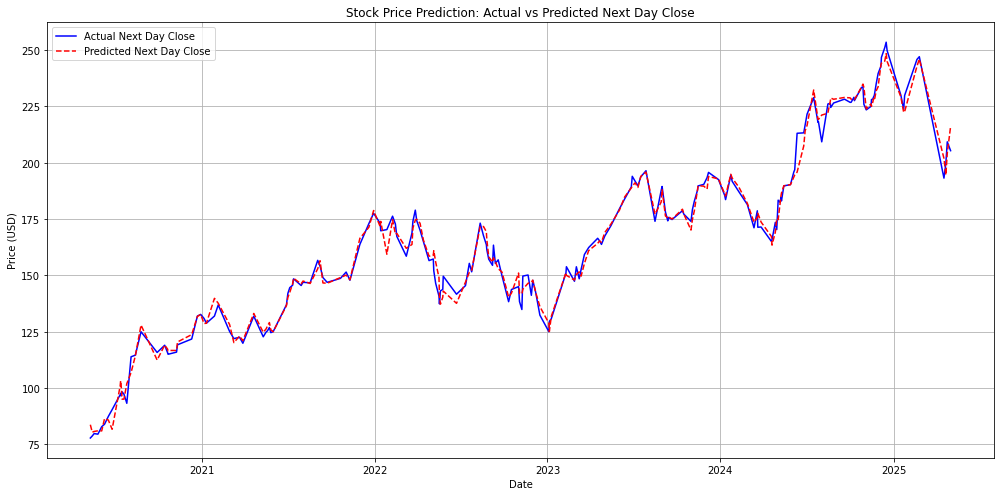

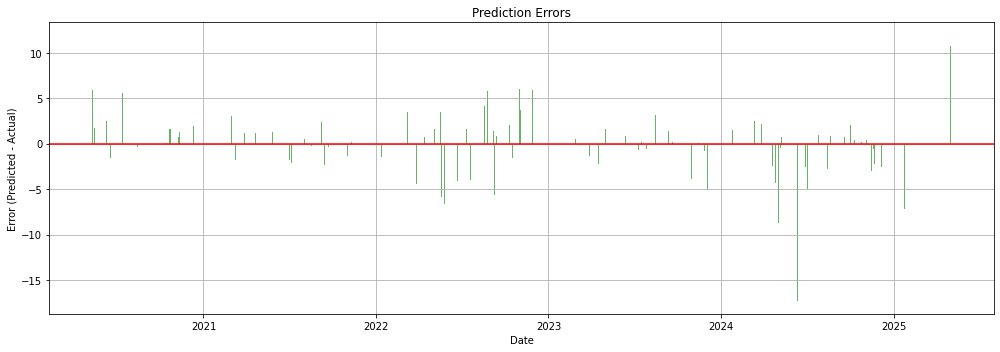

In [0]:
# Convert Spark DataFrame to pandas for visualization
pandas_predictions = pipeline_predictions.select('Date', close_col, 'NextDayClose', 'prediction').orderBy('Date').toPandas()

# Create a visualization of actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot actual next day closing prices
plt.plot(pandas_predictions['Date'], pandas_predictions['NextDayClose'], 
         label='Actual Next Day Close', color='blue')

# Plot predicted next day closing prices
plt.plot(pandas_predictions['Date'], pandas_predictions['prediction'], 
         label='Predicted Next Day Close', color='red', linestyle='--')

plt.title('Stock Price Prediction: Actual vs Predicted Next Day Close')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate and plot prediction errors
plt.figure(figsize=(14, 5))
pandas_predictions['error'] = pandas_predictions['prediction'] - pandas_predictions['NextDayClose']
plt.bar(pandas_predictions['Date'], pandas_predictions['error'], color='green', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Prediction Errors')
plt.xlabel('Date')
plt.ylabel('Error (Predicted - Actual)')
plt.grid(True)
plt.tight_layout()
plt.show()


Trading Strategy Results:


Date,close,prediction,Signal,MarketReturn,StrategyReturn
2020-05-11T00:00:00.000+0000,78.7525,83.75217673687422,1,null,0.0
2020-05-15T00:00:00.000+0000,76.9275,80.43883148221344,1,-0.023173867496269998,-0.023173867496269998
2020-05-19T00:00:00.000+0000,78.285,80.76158381987575,1,0.017646485327093717,0.017646485327093717
2020-05-27T00:00:00.000+0000,79.5275,81.0530413442958,1,0.015871495177875797,0.015871495177875797
2020-06-04T00:00:00.000+0000,80.58,81.00528979209797,1,0.013234415768130456,0.013234415768130456
2020-06-10T00:00:00.000+0000,88.21,86.46364185592185,-1,0.09468850831471824,0.09468850831471824
2020-06-18T00:00:00.000+0000,87.9325,85.83212214710407,-1,-0.0031459018251897655,0.0031459018251897655
2020-06-26T00:00:00.000+0000,88.4075,81.72895405547357,-1,0.0054018707531344416,-0.0054018707531344416
2020-07-13T00:00:00.000+0000,95.4775,101.03802432900433,1,0.07997059073042453,-0.07997059073042453
2020-07-14T00:00:00.000+0000,97.0575,103.25795023809525,1,0.016548401455840363,0.016548401455840363


Total Market Return: 170.87%
Total Strategy Return: 58.38%


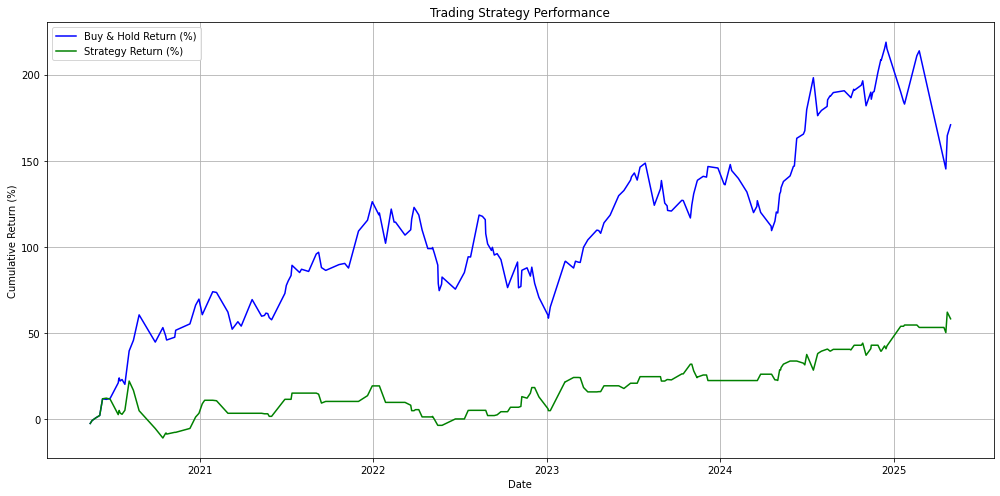

In [0]:
from pyspark.sql.functions import when, lit

# Define a simple trading strategy based on predictions
trading_data = pipeline_predictions.withColumn(
    'Signal', 
    when(col('prediction') > col(close_col) * 1.005, 1)  # Buy signal when predicted up >0.5%
    .when(col('prediction') < col(close_col) * 0.995, -1)  # Sell signal when predicted down >0.5%
    .otherwise(0)  # Hold
)

# Calculate hypothetical returns
windowSpec = Window.orderBy('Date')
trading_data = trading_data.withColumn('PrevSignal', lag('Signal', 1).over(windowSpec))
trading_data = trading_data.withColumn('PrevClose', lag(close_col, 1).over(windowSpec))

# Daily market return (for comparison)
trading_data = trading_data.withColumn(
    'MarketReturn', 
    (col(close_col) - col('PrevClose')) / col('PrevClose')
)

# Strategy return
trading_data = trading_data.withColumn(
    'StrategyReturn',
    when(col('PrevSignal') == 1, col('MarketReturn'))  # Long position return
    .when(col('PrevSignal') == -1, -col('MarketReturn'))  # Short position return
    .otherwise(0)  # No position, no return
)

# Display trading results
print("\nTrading Strategy Results:")
display(trading_data.select('Date', close_col, 'prediction', 'Signal', 'MarketReturn', 'StrategyReturn').orderBy('Date').limit(10))

# Convert to pandas for total return calculation and visualization
pandas_trading = trading_data.select('Date', 'MarketReturn', 'StrategyReturn').orderBy('Date').na.drop().toPandas()

# Calculate cumulative returns
pandas_trading['CumulativeMarket'] = (1 + pandas_trading['MarketReturn']).cumprod() - 1
pandas_trading['CumulativeStrategy'] = (1 + pandas_trading['StrategyReturn']).cumprod() - 1

# Display total returns
market_return = pandas_trading['CumulativeMarket'].iloc[-1] * 100
strategy_return = pandas_trading['CumulativeStrategy'].iloc[-1] * 100
print(f"Total Market Return: {market_return:.2f}%")
print(f"Total Strategy Return: {strategy_return:.2f}%")

# Visualize cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(pandas_trading['Date'], pandas_trading['CumulativeMarket'] * 100, 
         label='Buy & Hold Return (%)', color='blue')
plt.plot(pandas_trading['Date'], pandas_trading['CumulativeStrategy'] * 100, 
         label='Strategy Return (%)', color='green')
plt.title('Trading Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
# Define lookahead windows for each strategy
strategy_windows = {
    "daily": 1,
    "monthly": 21,
    "quarterly": 63,
    "yearly": 252
}

# Apply logic for each strategy
for name, offset in strategy_windows.items():
    # Future price column
    future_col = f"future_price_{name}"
    spark_df = spark_df.withColumn(future_col, lead("close", offset).over(Window.orderBy("date")))

    # Percentage return
    return_col = f"return_{name}"
    spark_df = spark_df.withColumn(
        return_col,
        ((col(future_col) - col("close")) / col("close")) * 100
    )

    # Thresholds
    if name == "daily":
        buy, sell = 2.5, -2.5
    elif name == "monthly":
        buy, sell = 5.0, -3.0
    elif name == "quarterly":
        buy, sell = 8.0, -5.0
    elif name == "yearly":
        buy, sell = 15.0, -10.0

    # Advice column
    advice_col = f"{name}_advice"
    spark_df = spark_df.withColumn(
        advice_col,
        when(col(return_col) >= buy, "Buy")
        .when(col(return_col) <= sell, "Sell")
        .otherwise("Hold")
    )

# Final selection of columns
strategy_columns = ["date", "close"] + [f"{name}_advice" for name in strategy_windows]
strategy_df = spark_df.select(*strategy_columns)

# Show result
strategy_df.orderBy("date").show(30, truncate=False)